In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
from PIL import Image
import torchvision.transforms as transforms
import torchvision.models as models
import torch.nn.functional as F
from copy import deepcopy
import cv2

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

#Загружаем и предобрабатываем изображения

In [3]:
imsize = 512 if torch.cuda.is_available() else 128 #если cuda недоступна, то меньший размер изображения

In [4]:
inp_transform = transforms.Compose([
    transforms.Resize((imsize, imsize)), #меняем размер изображения в зависимости от наличия/отсутствия cuda
    transforms.ToTensor()]) #переводим в тензор, масштабируем

In [5]:
def image_loader(img):
  """функция загрузки и преобразования исходного изображения.
  Меняем размер изображения а зависимости от доступности cuda,
  масштабируем и переводим в тензор,
  добавляем размерность батча (=1) по требовааниям входных данных модели
  """
  image = Image.open(img)
  image = inp_transform(image).unsqueeze(0) #добавляем размерность батча
  #переносим на device, переводим в float32, т.к в torch по умолчаеию тип данных float32
  return image.to(device, torch.float32)

In [ ]:
#style_img = image_loader('/content/picasso.jpg') #загружаем изображения со стилем
#content_img = image_loader('/content/dancing.jpg') #загружаем исходное изображение

In [6]:
content_img = image_loader('/content/Cheb.jpg') #загружаем исходное изображение

In [94]:
style_img = image_loader('/content/hohloma.jpg') #загружаем изображения со стилем

In [8]:
style_img.shape

torch.Size([1, 3, 512, 512])

In [ ]:
content_img.size()

torch.Size([1, 3, 512, 512])

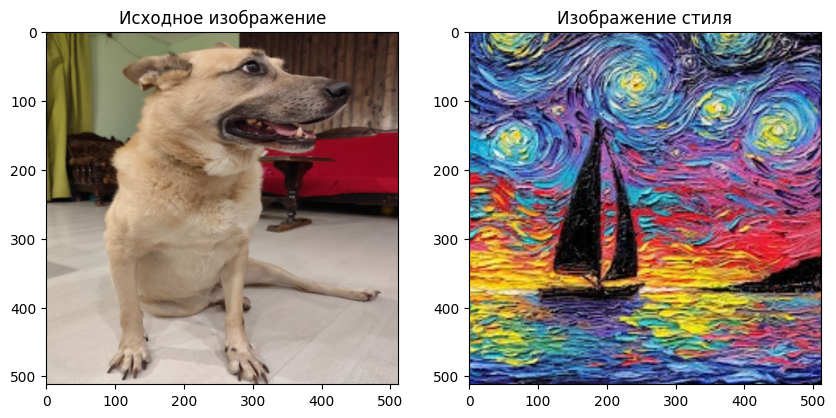

In [9]:
plt.figure(figsize = (10,10))
plt.subplot(1,2,1)
#переносим на cpu, переводим в numpy, переносим кол-во каналов исходя из треб. plt
plt.imshow(content_img[0,...].cpu().numpy().transpose(1,2,0))
plt.title('Исходное изображение')

plt.subplot(1,2,2)
plt.imshow(style_img[0,...].cpu().numpy().transpose(1,2,0))
plt.title('Изображение стиля')

plt.show()

In [10]:
assert style_img.size() == content_img.size(), "Изображения должны быть одинакового размера"

#Задаем функции потерь и матрицу Грама

In [11]:
class ContentLoss(nn.Module):
  def __init__(self, target):
    super().__init__()
    self.target = target.detach() #отсоединяем исходное изображение от графа вычислений чтобы не менять его

  def forward(self, input):
    #вычисляем ф-цию потерь- сравниваем изображение на входе с исходным изображением
    self.loss = F.mse_loss(input, self.target)
    return input

In [12]:
def gram_matrix(input):
  b,c,h,w = input.size() #b - кол-во батчей (=1), c - кол-во каналов, h*w - ширина *высота изобр
  #меняем размер входящего тензора.
  #Кол-во строк = кол-ву каналов; в каждой строке вытянутые в вектор значения каждого канала
  features = input.view(b*c, h*w)
  #print(features.size())
  gram = torch.mm(features, features.t()) #формируем матрицу Грама
  #нормализуем значения матрицы Грама
  return gram.div(b*c*h*w)

In [13]:
class StyleLoss(nn.Module):
  def __init__(self, target_feature):
    super().__init__()
    self.target = gram_matrix(target_feature).detach()

  def forward(self, input):
    gram = gram_matrix(input)
    self.loss = F.mse_loss(gram, self.target) #считаем ф-цию потерь между матр.Грама входного и исходного изображений
    return input


In [ ]:
content_img.size()

torch.Size([1, 3, 512, 512])

In [ ]:
#проверить размерность внутреннего тензора признаков
test_img = gram_matrix(content_img)

In [ ]:
#проверить размерность полученной матрицы Грама
test_img.size()

torch.Size([3, 3])

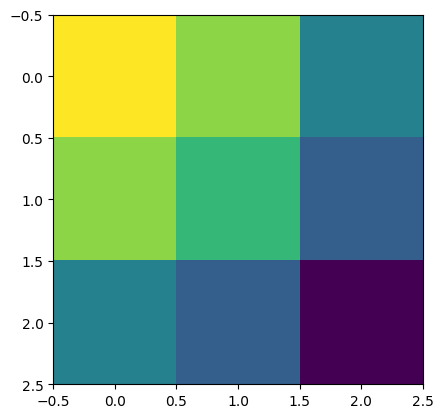

In [ ]:
#посмотреть, какая матрица Грама для исходного изображения
plt.imshow(test_img.cpu().numpy())

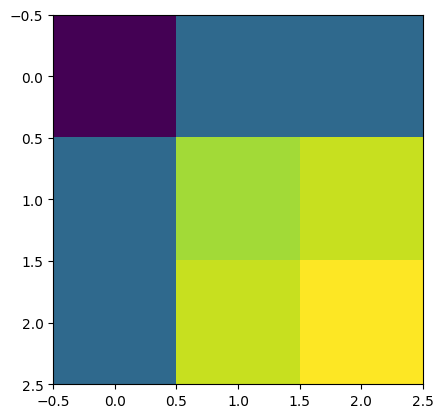

In [ ]:
#посмотреть на матрицу Грама стилевого изображения
test_img2 = gram_matrix(style_img)
plt.imshow(test_img2.cpu().numpy())
plt.show()

#Создаем модель transfer learning

In [14]:
#за основу берем предобученную сеть vgg19, переволим в режиим предсказания чтобы не менять веса
cnn = models.vgg19(pretrained = True).features.to(device).eval()

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


100%|██████████| 548M/548M [00:03<00:00, 144MB/s]


In [ ]:
#вывести структуру cnn
cnn

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

In [77]:
#создаем список слоев, после которых будем считать ф-ции потерь и матрицы Грама
content_layers = ['conv_1'] #для исходного изображения только 1-й сверточный слой
#для извлечения паттернов стиля используем сверточные слои:
style_layers = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5', 'conv_6', 'conv_7',
                'conv_8', 'conv_9','conv_10', 'conv_11', 'conv_12', 'conv_13','conv_14',
                'conv_15', 'conv_16', 'conv_17','conv_18', 'conv_19', 'conv_20']

#content_layers = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5', 'conv_6', 'conv_7'] #для исходного изображения только 1-й сверточный слой

#style_layers = ['conv_8', 'conv_9','conv_10', 'conv_11', 'conv_12', 'conv_13','conv_14',
  #              'conv_15', 'conv_16', 'conv_17','conv_18', 'conv_19', 'conv_20']

def create_model_losses(
    cnn,
    style_img, content_img,
    content_layers = content_layers,
    style_layers = style_layers):
  """Ф-ция создания модели переноса стиля из нужных слоев
    и подсчета ф-ций потерь
  """
  cnn = deepcopy(cnn) #создаем копию исходной сети чтобы не портить исходную и выбирать из нее нужные слои

  #создаем пустые списки потерь содержания и стиля
  content_losses = []
  style_losses = []

  model = nn.Sequential() #создаем пустую модель, в которую потом будем сохранять нужные слои
  i = 0 #задаем счетчик сверточных слоев
  #проходим по слоям и добавляем номера в названия для удобства дальнейшего использования
  #затем добавояем в model
  for layer in cnn.children():
    if isinstance(layer, nn.Conv2d):
      i+=1
      name = 'conv_{}'.format(i)
    elif isinstance(layer, nn.ReLU):
      name = 'relu_{}'.format(i)
      layer = nn.ReLU(inplace=False)
    elif isinstance(layer, nn.MaxPool2d):
      name = 'pool_{}'.format(i)
    elif isinstance(layer, nn.BatchNorm2d):
      name = 'bn_{}'.format(i)
    else:
      raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

    model.add_module(name, layer)

    if name in content_layers:
      #если слой входит в список слове, для которых считаем content loss
      target = model(content_img).detach()  #пропускаем исходное изображение через слой
      cont_loss = ContentLoss(target) #считаем отклонение от исходного изображения
      model.add_module("conten_loss_{}".format(i), cont_loss)
      content_losses.append(cont_loss)

    if name in style_layers:
      #если слой входит в список слоев, для которых считаем style_loss
      target_feature = model(style_img).detach()
      stl_loss = StyleLoss(target_feature)
      model.add_module("style_loss_{}".format(i), stl_loss)
      style_losses.append(stl_loss)

  for i in range(len(model) - 1, -1, -1):
    if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
      break

  model = model[:(i+1)] #убираем слои после contentloss или style loss

  return model, style_losses, content_losses


In [91]:
input_img = content_img.clone() #копируем изображение, чтобы не портить исходное

In [17]:
def inp_optimizer(input_img):
  #указываем, что для этого изображения нужно считать и сохранять градиенты
  optimizer = optim.LBFGS([input_img.requires_grad_()])
  return optimizer

In [18]:
def run_style_transfer(
    cnn,
    content_img, style_img,
    input_img,
    num_steps = 300,
    style_weight = 10000000, content_weight = 1):
  print('Строится модель переноса стиля')

  model, style_losses, content_losses = create_model_losses(cnn, style_img, content_img)
  optimizer = inp_optimizer(input_img)

  print('Подгоняем')
  run = [0] #задаем счетчик
  while run[0] < num_steps:
    def closure():
      input_img.data.clamp_(0, 1) #обрезаем значения <0 <1 входного изображения (inplace)
      optimizer.zero_grad() #обнуляем грандиенты чтобы не накопить лишнего
      model(input_img) #вычисляем loss ф-ции модели
      style_score = 0
      content_score = 0

      for sl in style_losses:
        style_score += sl.loss #суммируем полученные loss
      for cl in content_losses:
        content_score += cl.loss

      style_score *= style_weight #умножаем на веса
      content_score *= content_weight

      loss = style_score + content_score #вычисляем общую loss
      loss.backward() #вычисляем градиенты

      run[0] += 1
      if run[0] % 50 == 0:
        print("run {}:".format(run))
        print('Style Loss : {:4f} Content Loss: {:4f}'.format(
                    style_score.item(), content_score.item()))
        print()

      return style_score + content_score

    optimizer.step(closure)
    input_img.data.clamp_(0,1) #еще раз обрезаем значения, вышедшие за пределы 0,1

    return input_img


#Кубизм

In [78]:
#style_weight=10000000, content_weight=0.001)
output = run_style_transfer(cnn,
                            content_img, style_img,
                            input_img,
                            style_weight=10000000, content_weight=0.00001)


Строится модель переноса стиля
Подгоняем


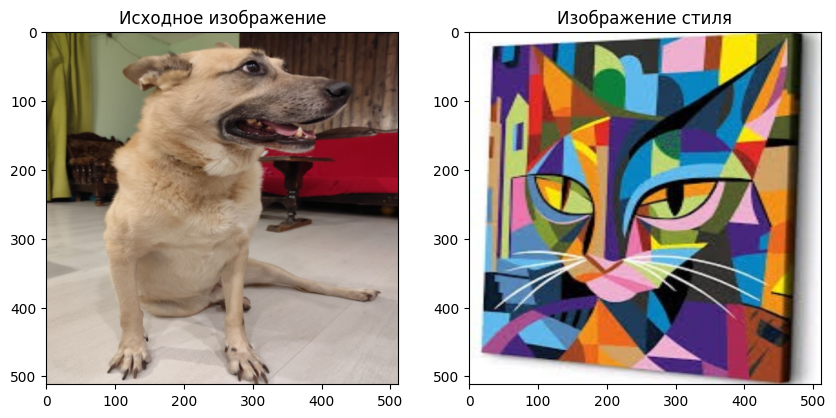

In [74]:
plt.figure(figsize = (10,10))
plt.subplot(1,2,1)
#переносим на cpu, переводим в numpy, переносим кол-во каналов исходя из треб. plt
plt.imshow(content_img[0,...].cpu().numpy().transpose(1,2,0))
plt.title('Исходное изображение')

plt.subplot(1,2,2)
plt.imshow(style_img[0,...].cpu().numpy().transpose(1,2,0))
plt.title('Изображение стиля')

plt.show()

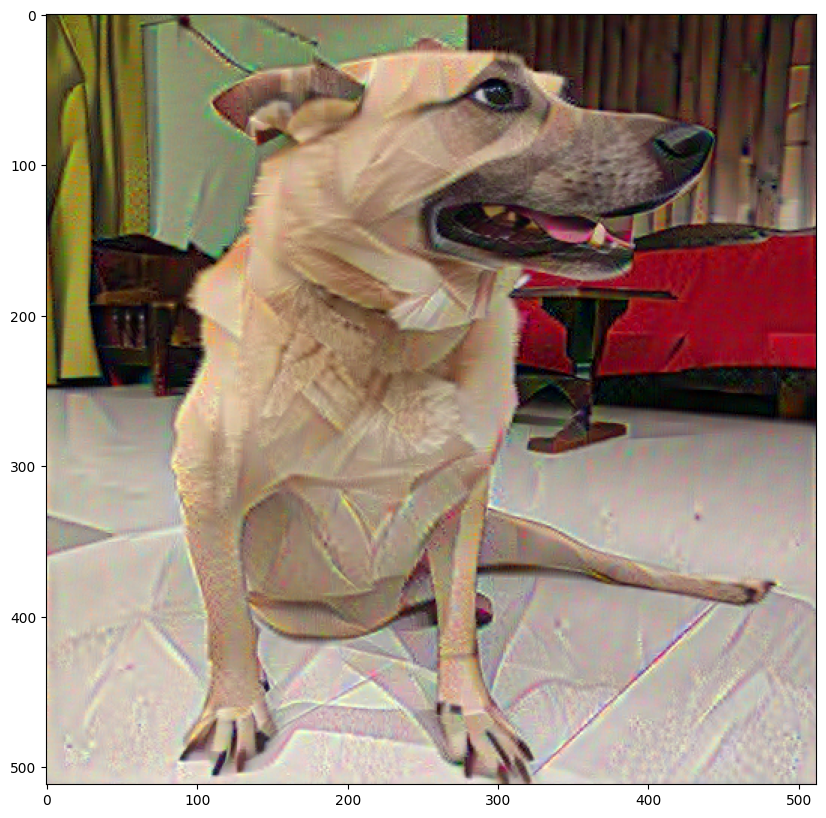

In [79]:
output = torch.squeeze(output, dim = 0) #удаляем размерность батча
output = output.permute(1,2,0) #переносим кол-во каналов на последнее место

plt.figure( figsize = (10,10))
plt.imshow(output.detach().cpu().numpy())

plt.show()

In [ ]:
cv2.imwrite('cheb_cube.jpg', (output*255).detach().cpu().numpy()[:, :, ::-1])

True

#Картина маслом

In [92]:
output = run_style_transfer(cnn,
                            content_img, style_img,
                            input_img,
                            style_weight=1000000000, content_weight=1)

Строится модель переноса стиля
Подгоняем


In [83]:
output.size()

torch.Size([1, 3, 512, 512])

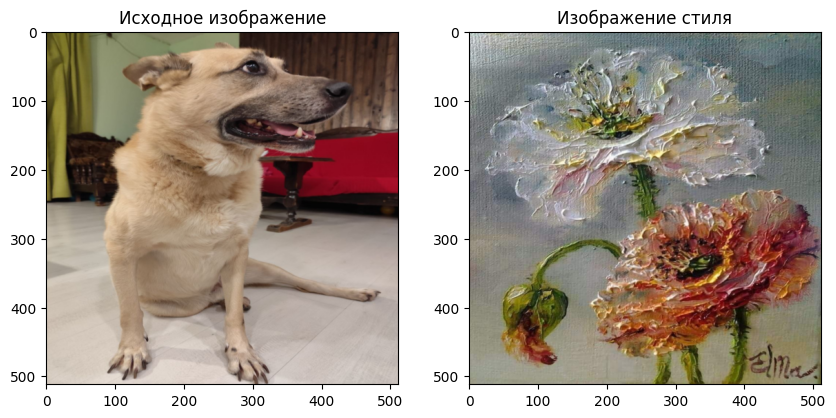

In [87]:
plt.figure(figsize = (10,10))
plt.subplot(1,2,1)
#переносим на cpu, переводим в numpy, переносим кол-во каналов исходя из треб. plt
plt.imshow(content_img[0,...].cpu().numpy().transpose(1,2,0))
plt.title('Исходное изображение')

plt.subplot(1,2,2)
plt.imshow(style_img[0,...].cpu().numpy().transpose(1,2,0))
plt.title('Изображение стиля')

plt.show()

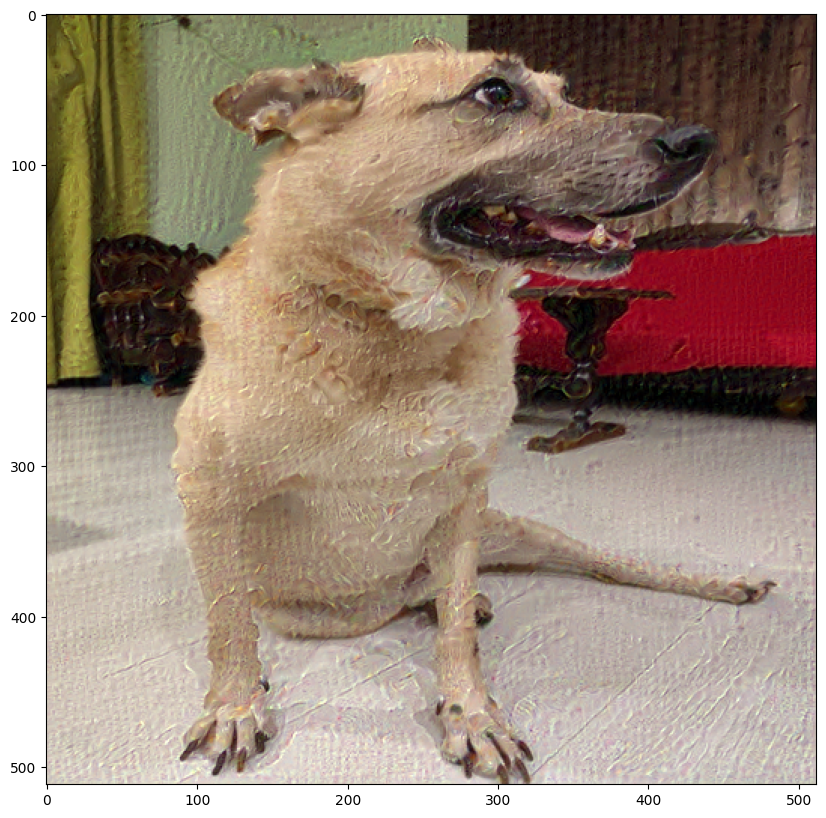

In [93]:
output = torch.squeeze(output, dim = 0) #удаляем размерность батча
output = output.permute(1,2,0) #переносим кол-во каналов на последнее место

plt.figure( figsize = (10,10))
plt.imshow(output.detach().cpu().numpy())

plt.show()

In [ ]:
cv2.imwrite('cheb_maslo.jpg', (output*255).detach().cpu().numpy()[:, :, ::-1])

True

#Хохлома

In [68]:
output = run_style_transfer(cnn,
                            content_img, style_img,
                            input_img,
                            style_weight=10000000000, content_weight=0.00001)

Строится модель переноса стиля
Подгоняем


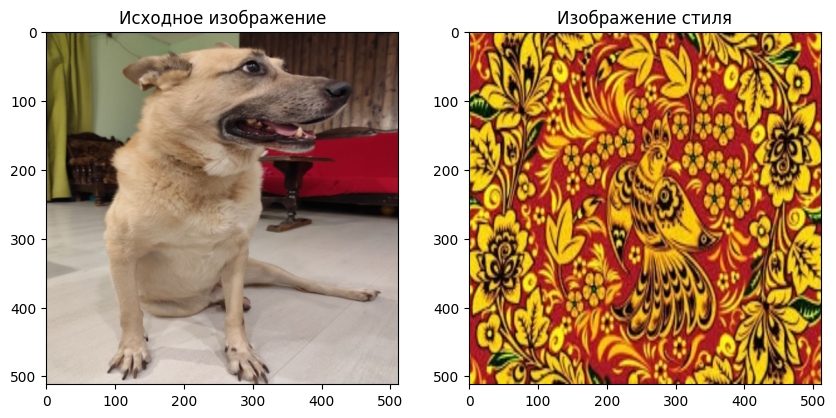

In [64]:
plt.figure(figsize = (10,10))
plt.subplot(1,2,1)
#переносим на cpu, переводим в numpy, переносим кол-во каналов исходя из треб. plt
plt.imshow(content_img[0,...].cpu().numpy().transpose(1,2,0))
plt.title('Исходное изображение')

plt.subplot(1,2,2)
plt.imshow(style_img[0,...].cpu().numpy().transpose(1,2,0))
plt.title('Изображение стиля')

plt.show()

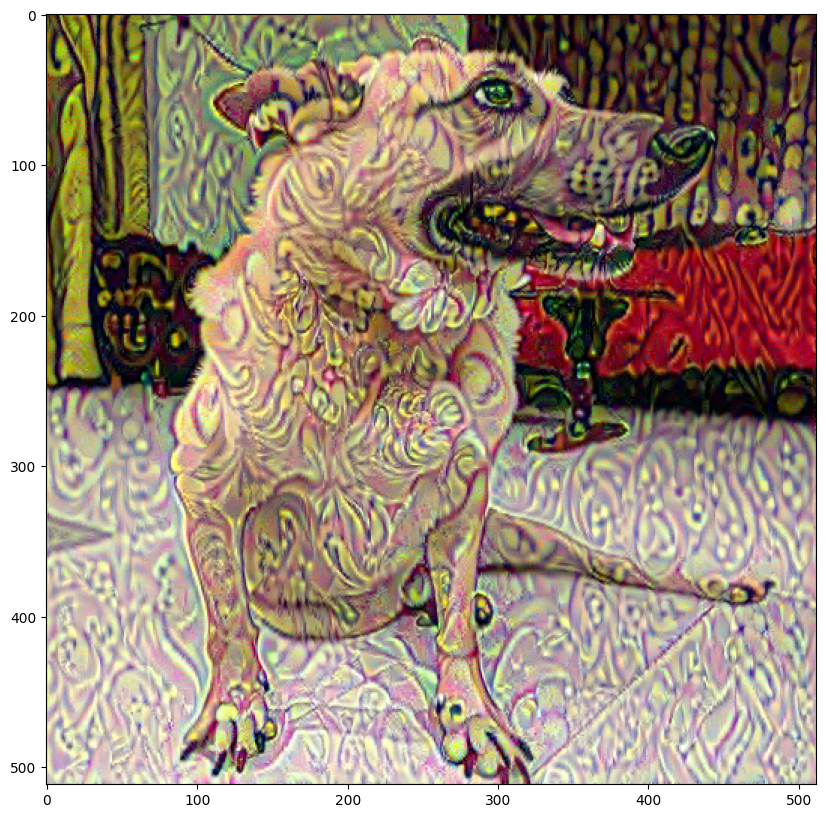

In [69]:
output = torch.squeeze(output, dim = 0) #удаляем размерность батча
output = output.permute(1,2,0) #переносим кол-во каналов на последнее место

plt.figure( figsize = (10,10))
plt.imshow(output.detach().cpu().numpy())

plt.show()

#Посмотреть на активации слоев внутри построенной модели

In [95]:
model, style_losses, content_losses = create_model_losses(cnn, style_img, content_img)

In [96]:
model

Sequential(
  (conv_1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conten_loss_1): ContentLoss()
  (style_loss_1): StyleLoss()
  (relu_1): ReLU()
  (conv_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (style_loss_2): StyleLoss()
  (relu_2): ReLU()
  (pool_2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv_3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (style_loss_3): StyleLoss()
  (relu_3): ReLU()
  (conv_4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (style_loss_4): StyleLoss()
  (relu_4): ReLU()
  (pool_4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv_5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (style_loss_5): StyleLoss()
  (relu_5): ReLU()
  (conv_6): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (style_loss_6): StyleLoss()
  (relu_6): ReLU()
  (conv_7): C

In [110]:
modulelist = list(model.modules())

In [111]:
modulelist

[Sequential(
   (conv_1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
   (conten_loss_1): ContentLoss()
   (style_loss_1): StyleLoss()
   (relu_1): ReLU()
   (conv_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
   (style_loss_2): StyleLoss()
   (relu_2): ReLU()
   (pool_2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
   (conv_3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
   (style_loss_3): StyleLoss()
   (relu_3): ReLU()
   (conv_4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
   (style_loss_4): StyleLoss()
   (relu_4): ReLU()
   (pool_4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
   (conv_5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
   (style_loss_5): StyleLoss()
   (relu_5): ReLU()
   (conv_6): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
   (style_loss_6): StyleLoss()
   (relu_6)

In [142]:
def layer_outputs(image):
  outputs = []
  names = []
  for layer in modulelist[1:]: #проходим по слоям модели
    #print(str(layer))
    image = layer(image) #прогоняем исходное изображение через слой
    #print('Добавили активацию')
    outputs.append(image) #добавляем полученную активацию  в список выходов
    #print('Добавили имя')
    names.append(str(layer)) #добавляем название слоя в список названий слоев
    #print(len(outputs))

  #готовим изображения к печати
  output_img = []
  for i in outputs:
    i =  i.squeeze(0) #убираем 1-е измерение батча
    i = torch.mean(i, dim = 0) #усредняем по всем каналам
    output_img.append(i.data.cpu().numpy())

  fig = plt.figure(figsize = (20,60))

  for i in range(len(output_img)):
    a = fig.add_subplot(13,4,i+1)
    imgplot = plt.imshow(output_img[i])
    a.set_title(names[i].partition('(')[0], fontsize=30)


In [143]:
#посмотреть актиивации слове от исходного изображения
layer_outputs(content_img)

Output hidden; open in https://colab.research.google.com to view.

In [144]:
#Посмотреть активации слоев от изображения стиля
layer_outputs(style_img)

Output hidden; open in https://colab.research.google.com to view.